# GRU 모델

피처는 통계적으로 유의미했던 변수로 선택

## 1.L1, L2 적용

In [12]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

**  머신러닝에서는 다중공선성 사용 안함! (제외하고 돌리기)

In [13]:
import pandas as pd
final_exchange = pd.read_csv('/content/final.csv')

- 시드 고정

In [14]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

- GRU 모델

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# Feature 및 Target 설정
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

# 데이터 준비
X = final_exchange[features].fillna(method='ffill').fillna(method='bfill')
y = final_exchange[target].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

# 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 시퀀스 생성
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# GRU 학습 및 평가
def train_gru(X_train_sel, X_test_sel, l1_value=0.0, l2_value=0.0):
    X_train_seq, y_train_seq = create_sequences(X_train_sel, y_train_scaled)
    X_test_seq, y_test_seq = create_sequences(X_test_sel, y_test_scaled)

    model = Sequential()
    model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                  kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(GRU(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
              callbacks=[early_stop], verbose=0)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    return rmse, mae, r2, y_test_actual, y_pred

# ✅ L1, L2 설정
l1_values = [0.0, 0.001, 0.01]
l2_values = [0.0, 0.001, 0.01]

# 결과 저장
all_results = []
y_test_actual_best = None
y_pred_best = None

# 선택법별 loop
for method_name, selector in [
    ("전진 선택법", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward')),
    ("후진 선택법", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='backward')),
    ("단계적 선택법", SFS(LinearRegression(), k_features='best', forward=True, floating=True, scoring='r2', cv=0))
]:
    if method_name == "단계적 선택법":
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = list(selector.k_feature_idx_)
    else:
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = selector.get_support(indices=True)

    selected_features = np.array(features)[selected_idx]
    print(f"\n✅ {method_name} 선택된 feature: {selected_features}")

    X_train_sel = X_train_scaled[:, selected_idx]
    X_test_sel = X_test_scaled[:, selected_idx]

    for l1 in l1_values:
        for l2 in l2_values:
            rmse, mae, r2, y_actual, y_pred = train_gru(X_train_sel, X_test_sel, l1, l2)

            # 전진 선택법 + L1=0.0 + L2=0.0일 경우 시각화용 값 저장
            if method_name == "전진 선택법" and l1 == 0.0 and l2 == 0.0:
                y_test_actual_best = y_actual
                y_pred_best = y_pred

            all_results.append({
                'Method': method_name,
                'L1': l1,
                'L2': l2,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            print(f"→ L1: {l1}, L2: {l2} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

# 결과 정리
results_df = pd.DataFrame(all_results)
print("\n=== 전체 결과 (RMSE 기준 정렬) ===")
print(results_df.sort_values(by='RMSE'))

<ipython-input-16-e716e8b68c82>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = final_exchange[features].fillna(method='ffill').fillna(method='bfill')



✅ 전진 선택법 선택된 feature: ['경제 심리 지수' '한국 외환 보유액' 'vix' '천연가스 가격' '한국 인플레이션율' 'M2' '아연 가격' '알루미늄 가격'
 '니켈 가격' '외국인 투자 금액']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 78.6367, MAE: 65.7434, R^2: 0.2709


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 81.9590, MAE: 67.2501, R^2: 0.2080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 98.0150, MAE: 81.9350, R^2: -0.1328


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 105.2792, MAE: 88.0299, R^2: -0.3069


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 116.4832, MAE: 94.6820, R^2: -0.5998


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 91.8267, MAE: 76.8791, R^2: 0.0058


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 80.7368, MAE: 69.4086, R^2: 0.2314


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 83.9933, MAE: 66.9423, R^2: 0.1682


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 138.1436, MAE: 119.0348, R^2: -1.2502

✅ 후진 선택법 선택된 feature: ['한국 외환 보유액' 'vix' '두바이 유가' 'Brent 유가' '천연가스 가격' '유연탄 가격' '한국 인플레이션율'
 '금 가격' '알루미늄 가격' '니켈 가격']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 87.0764, MAE: 79.3338, R^2: 0.1060


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 114.3248, MAE: 90.7531, R^2: -0.5411


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 118.5494, MAE: 91.3183, R^2: -0.6571


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 120.6791, MAE: 95.8451, R^2: -0.7172


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 119.2190, MAE: 93.1423, R^2: -0.6759


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 110.9398, MAE: 85.5506, R^2: -0.4512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 161.6954, MAE: 141.8309, R^2: -2.0828


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 91.9930, MAE: 75.9416, R^2: 0.0022


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 95.8801, MAE: 81.4574, R^2: -0.0839

✅ 단계적 선택법 선택된 feature: ['경제 심리 지수' '한국 외환 보유액' 'vix' 'WTI 유가' '한국 실업률' '두바이 유가' 'Brent 유가'
 '천연가스 가격' '유연탄 가격' '미국 주가지수' '한국 인플레이션율' '인플레이션 격차' '실질GDP성장률' 'M2'
 '금 가격' '구리 가격' '아연 가격' '알루미늄 가격' '니켈 가격' '외국인 투자 금액']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 93.4073, MAE: 81.6573, R^2: -0.0288


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 146.0474, MAE: 122.5250, R^2: -1.5150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 108.4895, MAE: 84.5396, R^2: -0.3878


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 129.4871, MAE: 109.5533, R^2: -0.9770


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 101.0468, MAE: 77.8199, R^2: -0.2039


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 108.7305, MAE: 84.1676, R^2: -0.3940


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 54.7492, MAE: 43.6545, R^2: 0.6466


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 108.1612, MAE: 94.6578, R^2: -0.3794


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 88.4012, MAE: 73.9503, R^2: 0.0786

=== 전체 결과 (RMSE 기준 정렬) ===
     Method     L1     L2        RMSE         MAE        R2
24  단계적 선택법  0.010  0.000   54.749177   43.654452  0.646567
0    전진 선택법  0.000  0.000   78.636710   65.743356  0.270875
6    전진 선택법  0.010  0.000   80.736780   69.408587  0.231411
1    전진 선택법  0.000  0.001   81.958997   67.250111  0.207964
7    전진 선택법  0.010  0.001   83.993296   66.942321  0.168158
9    후진 선택법  0.000  0.000   87.076397   79.333766  0.105969
26  단계적 선택법  0.010  0.010   88.401219   73.950327  0.078558
5    전진 선택법  0.001  0.010   91.826747   76.879121  0.005763
16   후진 선택법  0.010  0.001   91.993021   75.941555  0.002159
18  단계적 선택법  0.000  0.000   93.407323   81.657336 -0.028758
17   후진 선택법  0.010  0.010   95.880149   81.457374 -0.083949
2    전진 선택법  0.000  0.010   98.015008   81.935041 -0.132757
22  단계적 선택법  0.001  0.001  101.046800   77.819948 -0.203917
3    전진 선택법  0.001  0.000  10

| Method       | L1    | L2    | RMSE     | MAE     | R²     |
|--------------|-------|-------|----------|---------|--------|
| 단계적 선택법 | 0.01  | 0.000 | 54.7492  | 43.6545 | 0.6466 |
| 전진 선택법   | 0.00  | 0.000 | 78.6367  | 65.7434 | 0.2709 |
| 전진 선택법   | 0.01  | 0.000 | 80.7368  | 69.4086 | 0.2314 |
| 전진 선택법   | 0.00  | 0.001 | 81.9590  | 67.2501 | 0.2080 |
| 전진 선택법   | 0.01  | 0.001 | 83.9933  | 66.9423 | 0.1682 |
| 후진 선택법   | 0.00  | 0.000 | 87.0764  | 79.3338 | 0.1060 |
| 단계적 선택법 | 0.01  | 0.010 | 88.4012  | 73.9503 | 0.0786 |
| 전진 선택법   | 0.001 | 0.010 | 91.8267  | 76.8791 | 0.0058 |
| 후진 선택법   | 0.01  | 0.001 | 91.9930  | 75.9416 | 0.0022 |
| 단계적 선택법 | 0.00  | 0.000 | 93.4073  | 81.6573 | -0.0288 |
| 후진 선택법   | 0.01  | 0.010 | 95.8801  | 81.4574 | -0.0839 |


- 그래프

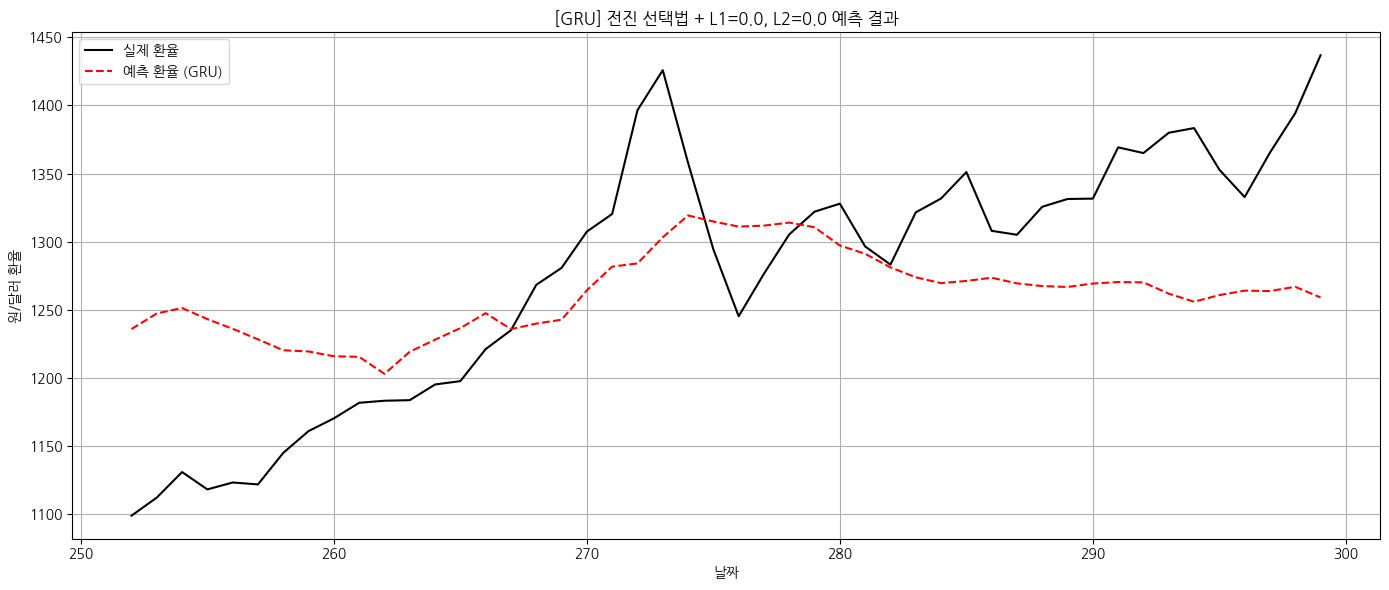

In [13]:
# 그래프 시각화
import matplotlib.pyplot as plt

if y_test_actual_best is not None and y_pred_best is not None:
    test_dates = y_test.index[-len(y_test_actual_best):]

    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_test_actual_best, label='실제 환율', color='black')
    plt.plot(test_dates, y_pred_best, label='예측 환율 (GRU)', color='red', linestyle='--')
    plt.title('[GRU] 전진 선택법 + L1=0.0, L2=0.0 예측 결과')
    plt.xlabel('날짜')
    plt.ylabel('원/달러 환율')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 2.GRU(Permutation Importance TOP10) 모델

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

GRU Permutation Importance (Top 10):
한국 인플레이션율: RMSE 증가량 = 18.2615
유연탄 가격: RMSE 증가량 = 14.4447
M2: RMSE 증가량 = 7.4163
금 가격: RMSE 증가량 = 6.5071
천연가스 가격: RMSE 증가량 = 4.4712
실질GDP성장률: RMSE 증가량 = 4.1755
알루미늄 

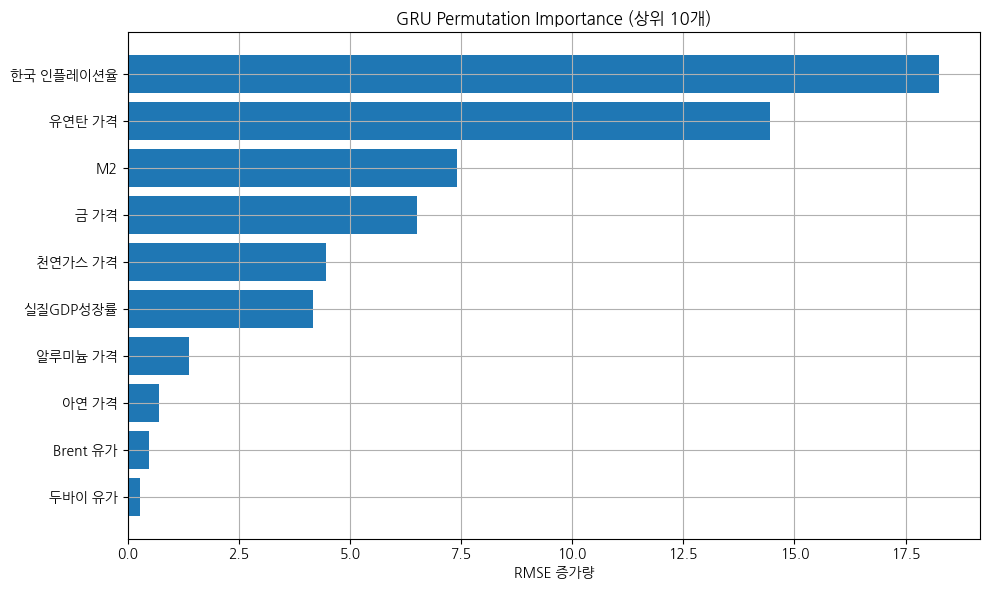

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ===== 1. 시드 고정 =====
import random, os, tensorflow as tf
def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(50)

# ===== 2. 데이터 준비 =====
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = final_exchange[features].ffill().bfill()
y = final_exchange[target].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ===== 3. GRU 모델 학습 =====
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ===== 4. Permutation Importance 계산 함수 =====
def permutation_importance_gru(model, X_seq, y_seq, feature_names, scaler_y):
    baseline_preds = model.predict(X_seq)
    baseline_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_seq),
                                               scaler_y.inverse_transform(baseline_preds)))

    importances = []
    for i in range(X_seq.shape[2]):
        X_permuted = X_seq.copy()
        np.random.shuffle(X_permuted[:, :, i])  # i번째 feature만 섞기

        preds = model.predict(X_permuted)
        rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_seq),
                                          scaler_y.inverse_transform(preds)))
        drop = rmse - baseline_rmse
        importances.append((feature_names[i], drop))

    importances.sort(key=lambda x: x[1], reverse=True)
    return importances

# ===== 5. 중요도 계산 및 시각화 =====
importances = permutation_importance_gru(model, X_test_seq, y_test_seq, features, scaler_y)

# 출력
print("\nGRU Permutation Importance (Top 10):")
for name, drop in importances[:10]:
    print(f"{name}: RMSE 증가량 = {drop:.4f}")

# 시각화
names = [x[0] for x in importances[:10]]
scores = [x[1] for x in importances[:10]]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("RMSE 증가량")
plt.title("GRU Permutation Importance (상위 10개)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2-1.선택된 TOP 10으로 GRU 학습

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step

📈 Top 10 Feature GRU 예측 성능
✅ RMSE: 57.6703
✅ MAE : 43.9310
✅ R²  : 0.6078


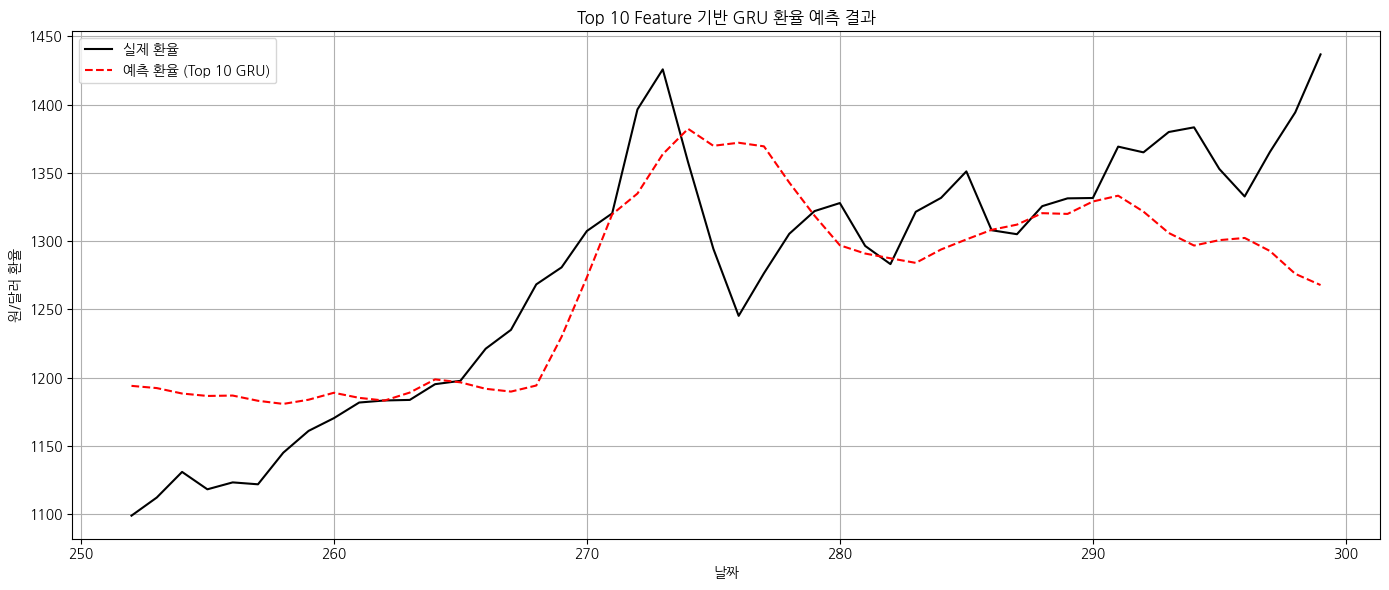

In [7]:
import numpy as np
import pandas as pd
import random, os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# ✅ 선택된 Top 10 피처
top10_features = [
    '한국 인플레이션율',
    '유연탄 가격',
    'M2',
    '금 가격',
    '천연가스 가격',
    '실질GDP성장률',
    '알루미늄 가격',
    '아연 가격',
    'Brent 유가',
    '두바이 유가'
]

# ✅ 데이터 준비
X_top10 = final_exchange[top10_features].ffill().bfill()
y = final_exchange['원/달러환율'].loc[X_top10.index]

X_train, X_test, y_train, y_test = train_test_split(X_top10, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ✅ GRU 모델 정의 및 학습
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ✅ 예측 및 성능 평가
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\n📈 Top 10 Feature GRU 예측 성능")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ R²  : {r2:.4f}")

# ✅ 시각화
import matplotlib.pyplot as plt

test_dates = y_test.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='실제 환율', color='black')
plt.plot(test_dates, y_pred, label='예측 환율 (Top 10 GRU)', color='red', linestyle='--')
plt.title('Top 10 Feature 기반 GRU 환율 예측 결과')
plt.xlabel('날짜')
plt.ylabel('원/달러 환율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.GRU(LASSO Top 10 Feature) 모델

✅ LASSO 기반 Top 10 피처:
['알루미늄 가격', '인플레이션 격차', 'vix', '경제 심리 지수', 'WTI 유가', '한국 외환 보유액', 'Brent 유가', '한국 실업률', '천연가스 가격', '유연탄 가격']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step

📈 GRU (LASSO Top 10 Feature) 성능
✅ RMSE: 108.4153
✅ MAE : 97.2188
✅ R²  : -0.3859


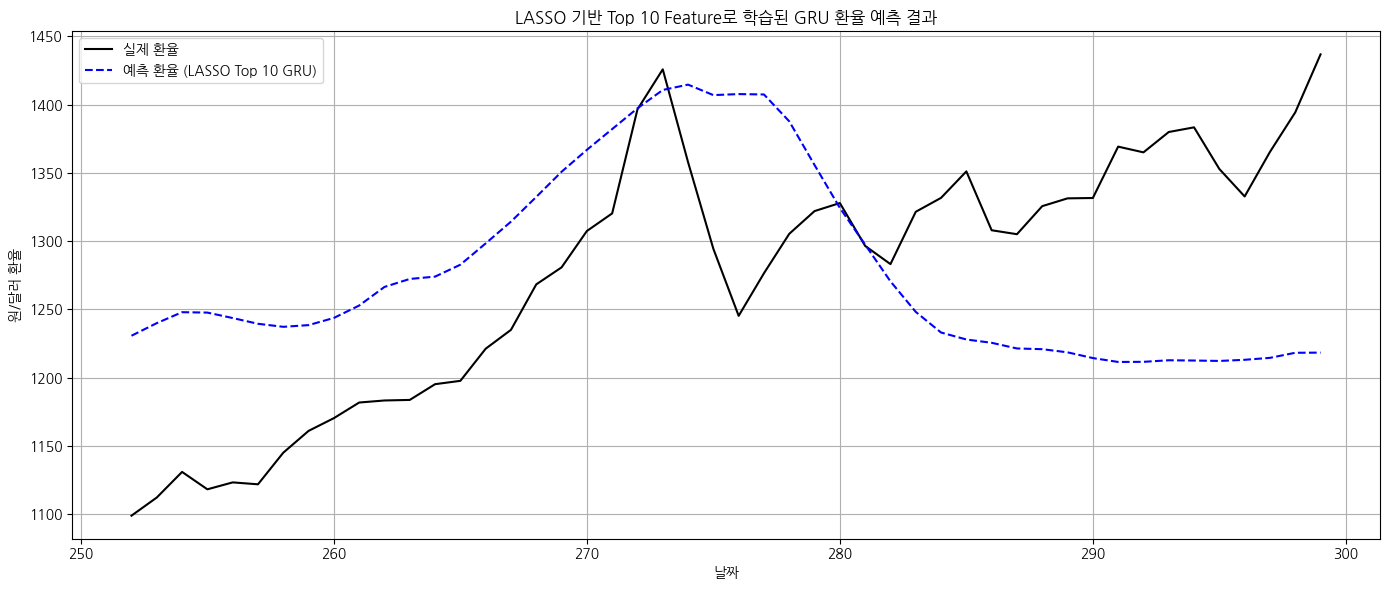

In [8]:
# ✅ 필요한 라이브러리
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# ✅ 전체 피처 정의
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

# ✅ 데이터 준비
X = final_exchange[features].ffill().bfill()
y = final_exchange[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ✅ LASSO 기반 Top 10 피처 선택
lasso = Lasso(alpha=0.01, random_state=50, max_iter=10000)
lasso.fit(X_train_scaled, y_train_scaled.ravel())
feature_importance = pd.Series(np.abs(lasso.coef_), index=features)
top10_lasso_features = feature_importance.sort_values(ascending=False).head(10).index.tolist()

print("✅ LASSO 기반 Top 10 피처:")
print(top10_lasso_features)

# ✅ Top 10 피처만 다시 스케일링 및 시퀀스 생성
X_top10 = final_exchange[top10_lasso_features].ffill().bfill()
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ✅ GRU 모델 학습
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ✅ 성능 평가
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\n📈 GRU (LASSO Top 10 Feature) 성능")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ R²  : {r2:.4f}")

# ✅ 예측 결과 시각화
test_dates = y_test.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='실제 환율', color='black')
plt.plot(test_dates, y_pred, label='예측 환율 (LASSO Top 10 GRU)', color='blue', linestyle='--')
plt.title('LASSO 기반 Top 10 Feature로 학습된 GRU 환율 예측 결과')
plt.xlabel('날짜')
plt.ylabel('원/달러 환율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.GRU(Random Forest기반 feature_importance Top 10) 모델

✅ Random Forest 기반 Top 10 피처:
['미국 주가지수', '천연가스 가격', '알루미늄 가격', 'M2', '니켈 가격', '경제 심리 지수', '아연 가격', 'vix', '실질GDP성장률', '인플레이션 격차']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step

📈 GRU (Random Forest Top 10 Feature) 성능
✅ RMSE: 103.2252
✅ MAE : 93.5408
✅ R²  : -0.2564


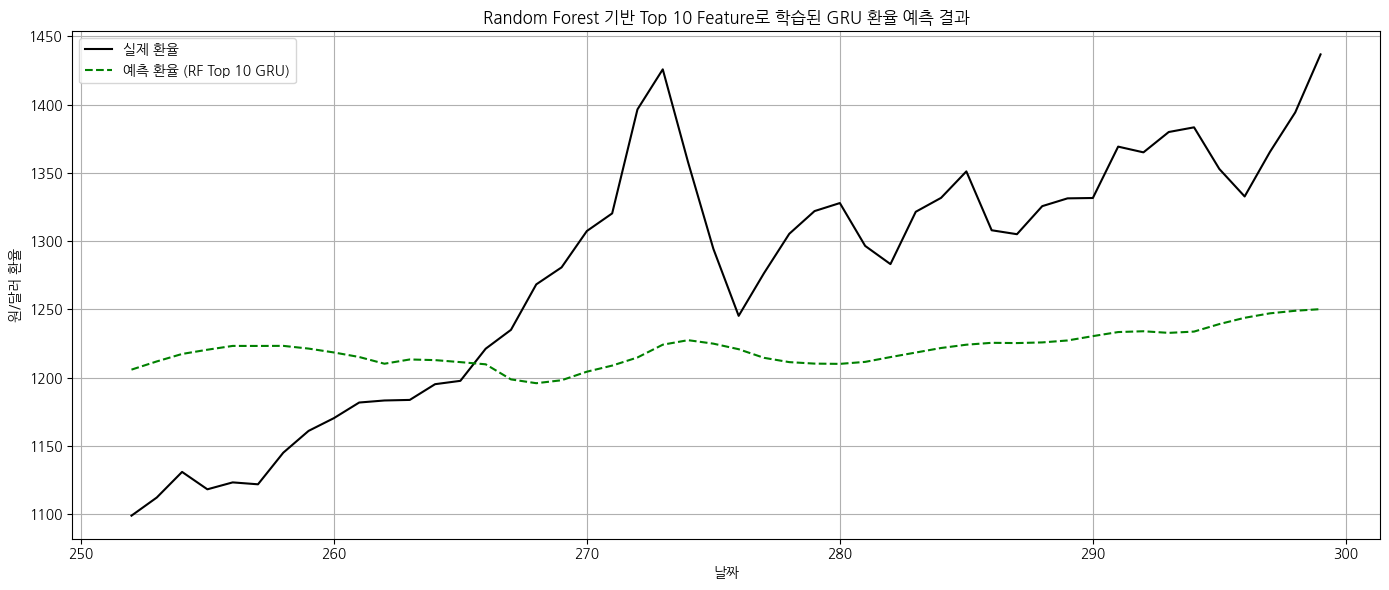

In [11]:
# ✅ 필요한 라이브러리
from sklearn.ensemble import RandomForestRegressor

# ✅ 1. Random Forest로 피처 중요도 계산(전체피처에서 다시 정의)
X_full = final_exchange[features].ffill().bfill()
y_full = final_exchange['원/달러환율'].loc[X_full.index]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, train_size=0.8, shuffle=False)

scaler_X_full = MinMaxScaler()
X_train_scaled_full = scaler_X_full.fit_transform(X_train_full)
X_test_scaled_full = scaler_X_full.transform(X_test_full)

scaler_y_dummy = MinMaxScaler()
y_train_scaled_full = scaler_y_dummy.fit_transform(y_train_full.values.reshape(-1, 1))

# ✅ RandomForestRegressor 학습 (20개 피처 전체 기준)
rf = RandomForestRegressor(n_estimators=100, random_state=50)
rf.fit(X_train_scaled_full, y_train_scaled_full.ravel())

# ✅ 정확한 index 매칭
rf_importance = pd.Series(rf.feature_importances_, index=X_full.columns)
top10_rf_features = rf_importance.sort_values(ascending=False).head(10).index.tolist()

print("✅ Random Forest 기반 Top 10 피처:")
print(top10_rf_features)


# ✅ 2. 선택된 Top 10 피처로 데이터 재구성
X_top10 = final_exchange[top10_rf_features].ffill().bfill()
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ✅ 3. GRU 모델 구성 및 학습
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ✅ 4. 성능 평가
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\n📈 GRU (Random Forest Top 10 Feature) 성능")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ R²  : {r2:.4f}")

# ✅ 5. 예측 시각화
test_dates = y_test.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='실제 환율', color='black')
plt.plot(test_dates, y_pred, label='예측 환율 (RF Top 10 GRU)', color='green', linestyle='--')
plt.title('Random Forest 기반 Top 10 Feature로 학습된 GRU 환율 예측 결과')
plt.xlabel('날짜')
plt.ylabel('원/달러 환율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 최종 결과 비교

| Feature Set                    | RMSE     | MAE      | R²     |
|--------------------------------|----------|----------|--------|
| Stepwise Top 10 (L1=0.01)      | 54.7492  | 43.6545  | 0.6466 |
| Permutation Importance Top 10  | 57.6703  | 43.9310  | 0.6078 |
| Random Forest Top 10           | 103.2252 | 93.5408  | -0.2564 |
| Lasso Top 10                   | 108.4153 | 97.2188  | -0.3859 |
